In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from aind_dynamic_foraging_basic_analysis.plot import plot_fip as pf
from aind_dynamic_foraging_basic_analysis.plot import plot_foraging_session as pb
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sns
from scipy import stats

In [2]:
from importlib import reload


# get the data, get the analysis specifications

In [3]:

import json
from pathlib import Path
import os

DATA_PATH: Path = Path("/data")  # TODO: don't hardcode
ANALYSIS_BUCKET = os.getenv("ANALYSIS_BUCKET")


input_model_paths = tuple(DATA_PATH.glob('job_dict/*'))
print(f"Found {len(input_model_paths)} input job models to run analysis on.")
analysis_specs = None

analysis_spec_path = tuple(DATA_PATH.glob("analysis_parameters.json"))
if analysis_spec_path:
    with open(analysis_spec_path[0], "r") as f:
        analysis_specs = json.load(f)

from analysis_pipeline_utils.analysis_dispatch_model import AnalysisDispatchModel
import utils as utils
from analysis_model import (
    SummaryPlotsAnalysisSpecification, SummaryPlotsAnalysisSpecificationCLI
)
for model_path in input_model_paths:
    with open(model_path, "r") as f:
        analysis_dispatch_inputs = AnalysisDispatchModel.model_validate(json.load(f))
    
    analysis_specification = SummaryPlotsAnalysisSpecification.model_validate(analysis_specs).model_dump()

Found 1 input job models to run analysis on.


# get the data and set them up right

In [4]:
import rachel_analysis_framework_utils as r_utils
import analysis_util
from plots import summary_plots
from aind_dynamic_foraging_basic_analysis.metrics import trial_metrics



In [5]:


parameters = analysis_specification

(df_sess, df_trials, df_events, df_fip) = r_utils.get_nwb_processed(analysis_dispatch_inputs.file_location, **parameters)


Saving channels: ['R_0', 'G_0', 'G_1']
CURRENTLY RUNNING 1/2: 726649_2024-09-12
--------------------------------------------------
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
CURRENTLY RUNNING 2/2: 726649_2024-09-16
--------------------------------------------------


/src/aind-dynamic-foraging-data-utils/src/aind_dynamic_foraging_data_utils/nwb_utils.py:483: UserWarning: Response time greater than minimum, something unusual happened
  warnings.warn("Response time greater than minimum, something unusual happened")


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Retrieving foraging model QLearning_L1F1_CK1_softmax
Query: {'analysis_spec.analysis_name': 'MLE fitting', 'analysis_spec.analysis_ver': 'first version @ 0.10.0', 'subject_id': '726649', 'session_date': '2024-09-12', 'analysis_results.fit_settings.agent_alias': 'QLearning_L1F1_CK1_softmax'}
Found 1 MLE fitting records!
Found 1 successful MLE fitting!


Get latent variables from s3: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Query: {'analysis_spec.analysis_name': 'MLE fitting', 'analysis_spec.analysis_ver': 'first version @ 0.10.0', 'subject_id': '726649', 'session_date': '2024-09-16', 'analysis_results.fit_settings.agent_alias': 'QLearning_L1F1_CK1_softmax'}
Found 1 MLE fitting records!
Found 1 successful MLE fitting!


Get latent variables from s3: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]
/src/aind-dynamic-foraging-data-utils/src/aind_dynamic_foraging_data_utils/enrich_dfs.py:378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ses.loc[:, "Q_chosen"] = chosen_values
/src/aind-dynamic-foraging-data-utils/src/aind_dynamic_foraging_data_utils/enrich_dfs.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ses.loc[:, "Q_unchosen"] = unchosen_values
/src/aind-dynamic-foraging-data-utils/src/aind_dynamic_foraging_data

In [6]:
# TODO: refactor this out to r_utils. 

##### PART I: REWARD #######
df_trials['reward_all'] = df_trials['earned_reward'] + df_trials['extra_reward']
# Compute num_reward_past and num_no_reward_past
df_trials['rewarded_prev'] = df_trials.groupby('ses_idx')['reward_all'].shift(1)  # Shift to look at past values

df_trials['num_reward_past'] = df_trials.groupby(
                        (df_trials['rewarded_prev'] != df_trials['reward_all']).cumsum()).cumcount() + 1

# Set 'NA' for mismatched reward types
df_trials.loc[df_trials['reward_all'] == 0, 'num_reward_past'] = df_trials.loc[df_trials['reward_all'] == 0, 'num_reward_past']* -1 

##### PART II: BINNING RPE #######
# get RPE binned columns. 
RPE_binned3_label_names = [str(np.round(i,2)) for i in np.arange(-1,0.99,1/3)]

bins = np.arange(-1,1.01,1/3)
bins[-1] = 1.001

df_trials['RPE-binned3'] = pd.cut(df_trials['RPE_earned'],# all versus earned not a huge difference
                    bins = bins, right = True, labels=RPE_binned3_label_names)

##### PART III: BINNING QCHOSEN #######
bins = [0.0, 1/3, 2/3, 1.01]
q_labels = ["Qch 0", "Qch 0.33", "Qch 0.66"]

q_bin = pd.cut(df_trials['Q_chosen'], bins=bins, labels=q_labels, include_lowest=True, right=True)
reward_label = df_trials['earned_reward'].map({True: "R+", False: "R-"})

# build combined label series (None where q_bin is NA)
reward_Qcat_series = pd.Series(
    np.where(q_bin.isna(), None, reward_label.astype(str) + " (" + q_bin.astype(str) + ")"),
    index=df_trials.index
)

# ordered categories you requested
Qch_binned3_label_names = [
    "R- (Qch 0)", "R- (Qch 0.33)", "R- (Qch 0.66)",
    "R+ (Qch 0)", "R+ (Qch 0.33)", "R+ (Qch 0.66)"
]

# assign final ordered categorical to dataframe (no intermediate column left behind)
df_trials['Qch-binned3'] = pd.Categorical(reward_Qcat_series, categories=Qch_binned3_label_names, ordered=True)

##### PART IV: GETTING STAY/LEAVE #######
_choice_shifted = df_trials.groupby('ses_idx')['choice'].shift(1)
df_trials['stay'] = df_trials['choice'] == _choice_shifted
df_trials['switch'] = df_trials['choice'] != _choice_shifted
df_trials['response_time'] = df_trials['choice_time_in_trial'] -  df_trials['goCue_start_time_in_trial']


(df_sess, nwbs_by_week) = analysis_util.get_dummy_nwbs_by_week(df_sess, df_trials, df_events, df_fip) 


# TODO: will need to refactor code so there's flexibility on the plots that come out
#       consult alex? or figure it out on my own. 
# get average activity 
data_column = 'data_z_norm'
alignment_event='choice_time_in_session'
rpe_slope_dict = {}
for channel in list(analysis_specification["channels"].keys()):
    avg_signal_col = summary_plots.output_col_name(channel, data_column, alignment_event)
    for nwb_week in nwbs_by_week:
    
        nwb_week = trial_metrics.get_average_signal_window_multi(
                        nwb_week,
                        alignment_event='choice_time_in_session',
                        offsets=[0.33, 1],
                        channel=channel,
                        data_column=data_column,
                        output_col = avg_signal_col
                    )

In [9]:
reload(pb)

<module 'aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session' from '/src/aind-dynamic-foraging-basic-analysis/src/aind_dynamic_foraging_basic_analysis/plot/plot_foraging_session.py'>

# new plotting

In [7]:
import plots.summary_plots as summary_plots

In [46]:
nwbs_by_week[0]

[726649_2024-09-12, 726649_2024-09-16]

am i being called twice?


2025-12-17 01:41:22,971 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/src/aind-dynamic-foraging-basic-analysis/src/aind_dynamic_foraging_basic_analysis/plot/plot_fip.py:219: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
2025-12-17 01:41:23,604 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-12-17 01:41:24,236 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-12-17 01:41:24,891 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-12-17 01:41:25,075 - INFO - Using categorical

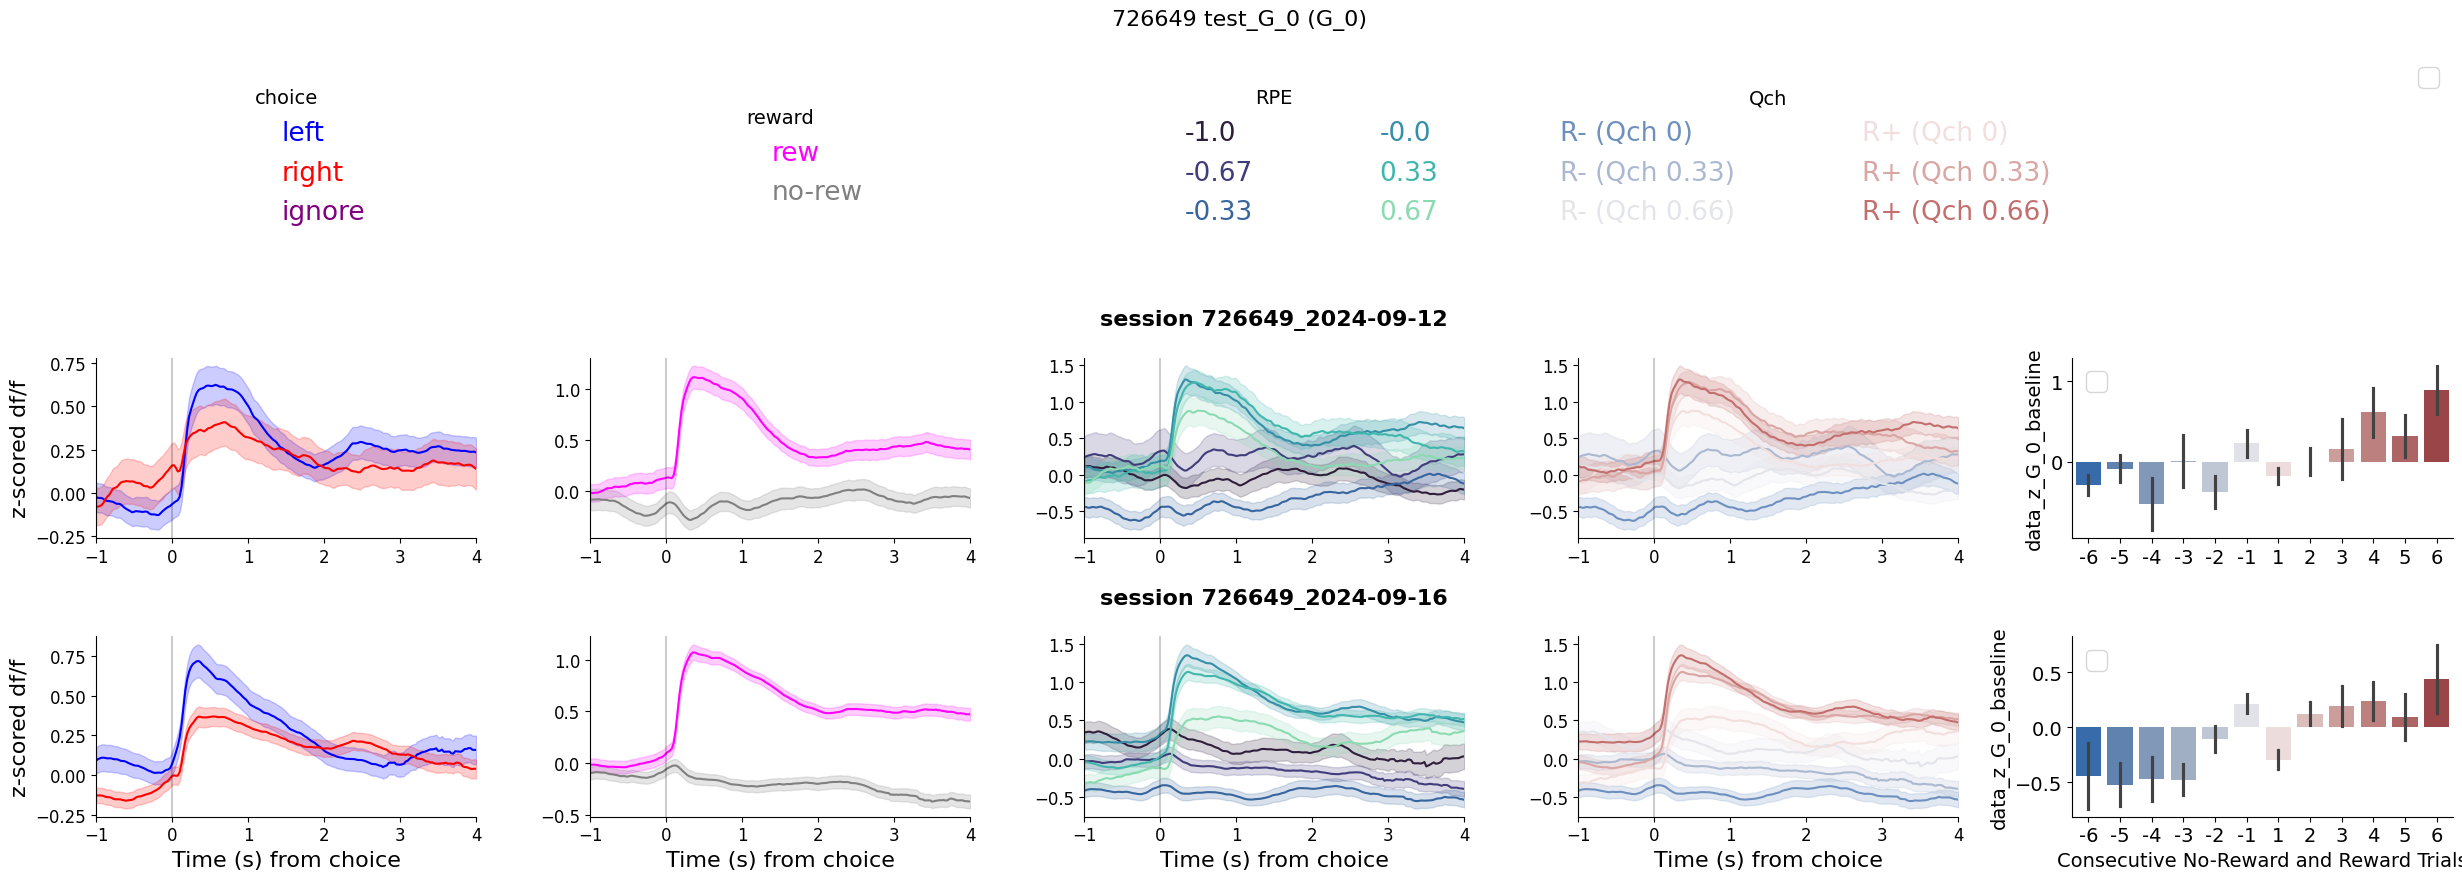

In [ ]:
summary_plots.plot_all_sess_PSTH(df_sess, nwbs_by_week[0], "G_0", "test_G_0", loc=None)

/src/aind-dynamic-foraging-basic-analysis/src/aind_dynamic_foraging_basic_analysis/plot/plot_foraging_session.py:452: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


ValueError: 'Upper Left' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

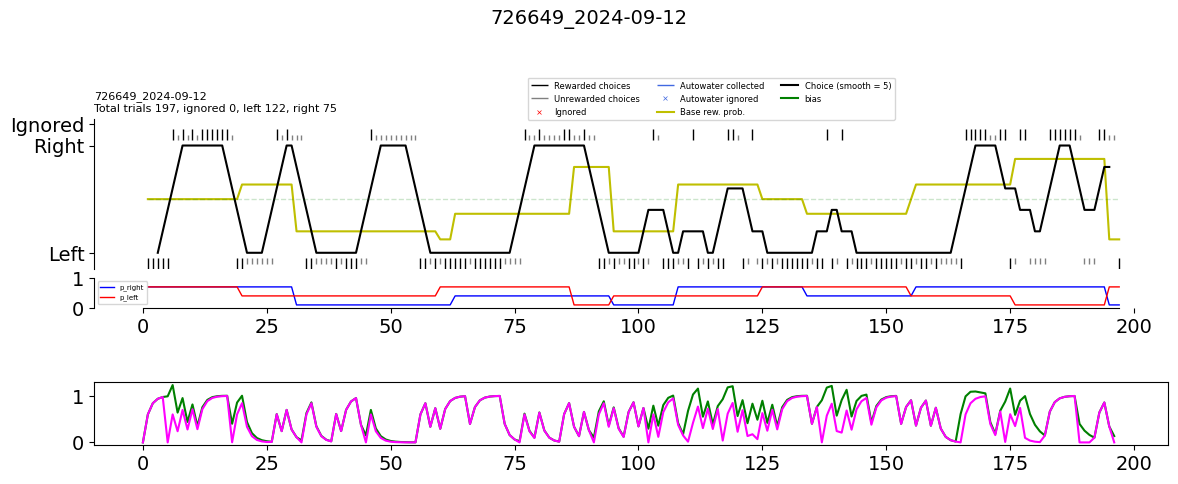

In [28]:
reload(summary_plots)

summary_plots.plot_per_channel_behavior_data(nwbs_by_week[0][0], loc=None)

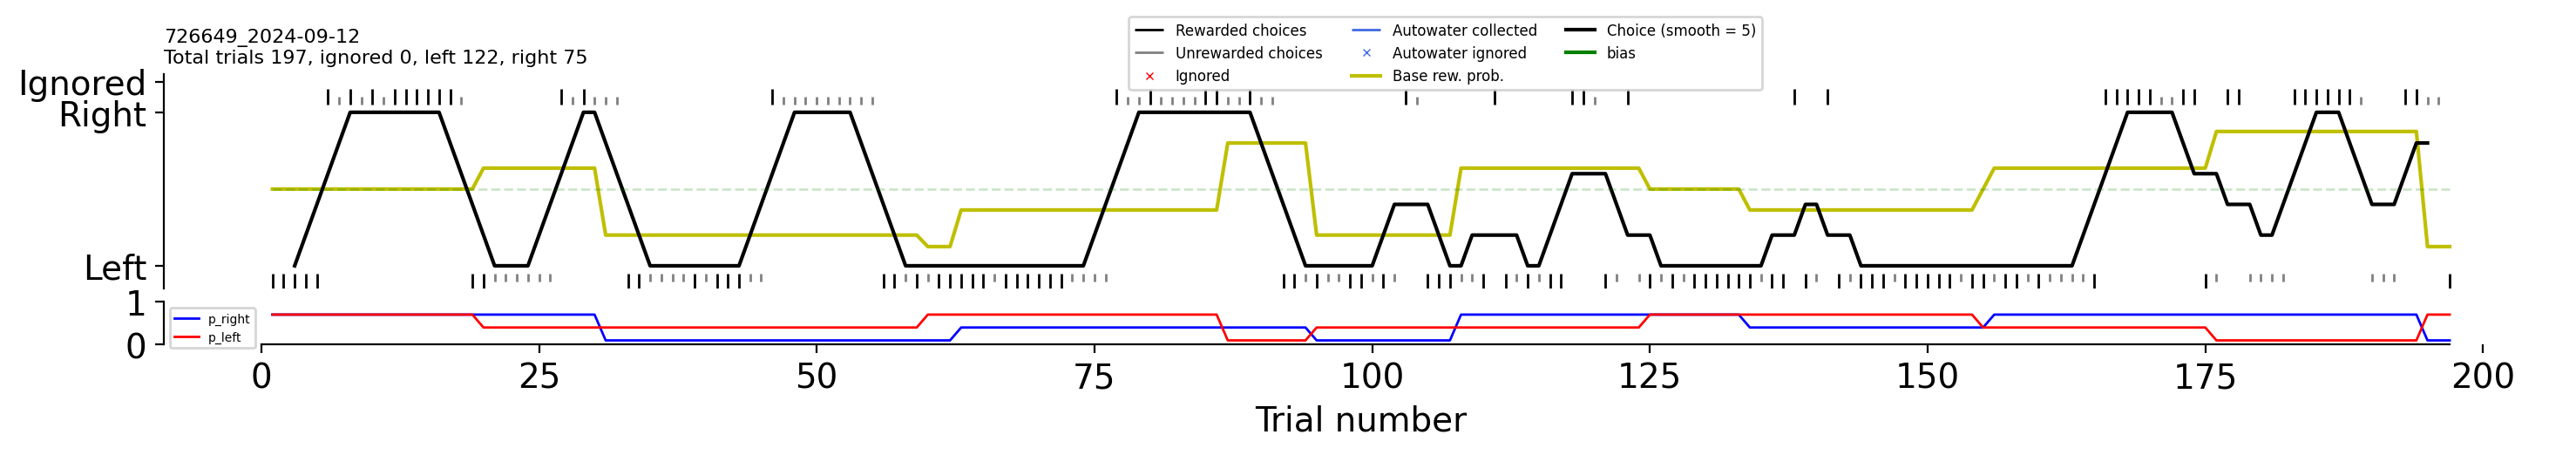

In [9]:

pb.plot_foraging_session_nwb(nwbs_by_week[0][0])

2025-12-15 23:47:24,415 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-12-15 23:47:26,532 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-12-15 23:47:31,024 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-12-15 23:47:32,363 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-12-15 23:47:32,576 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-

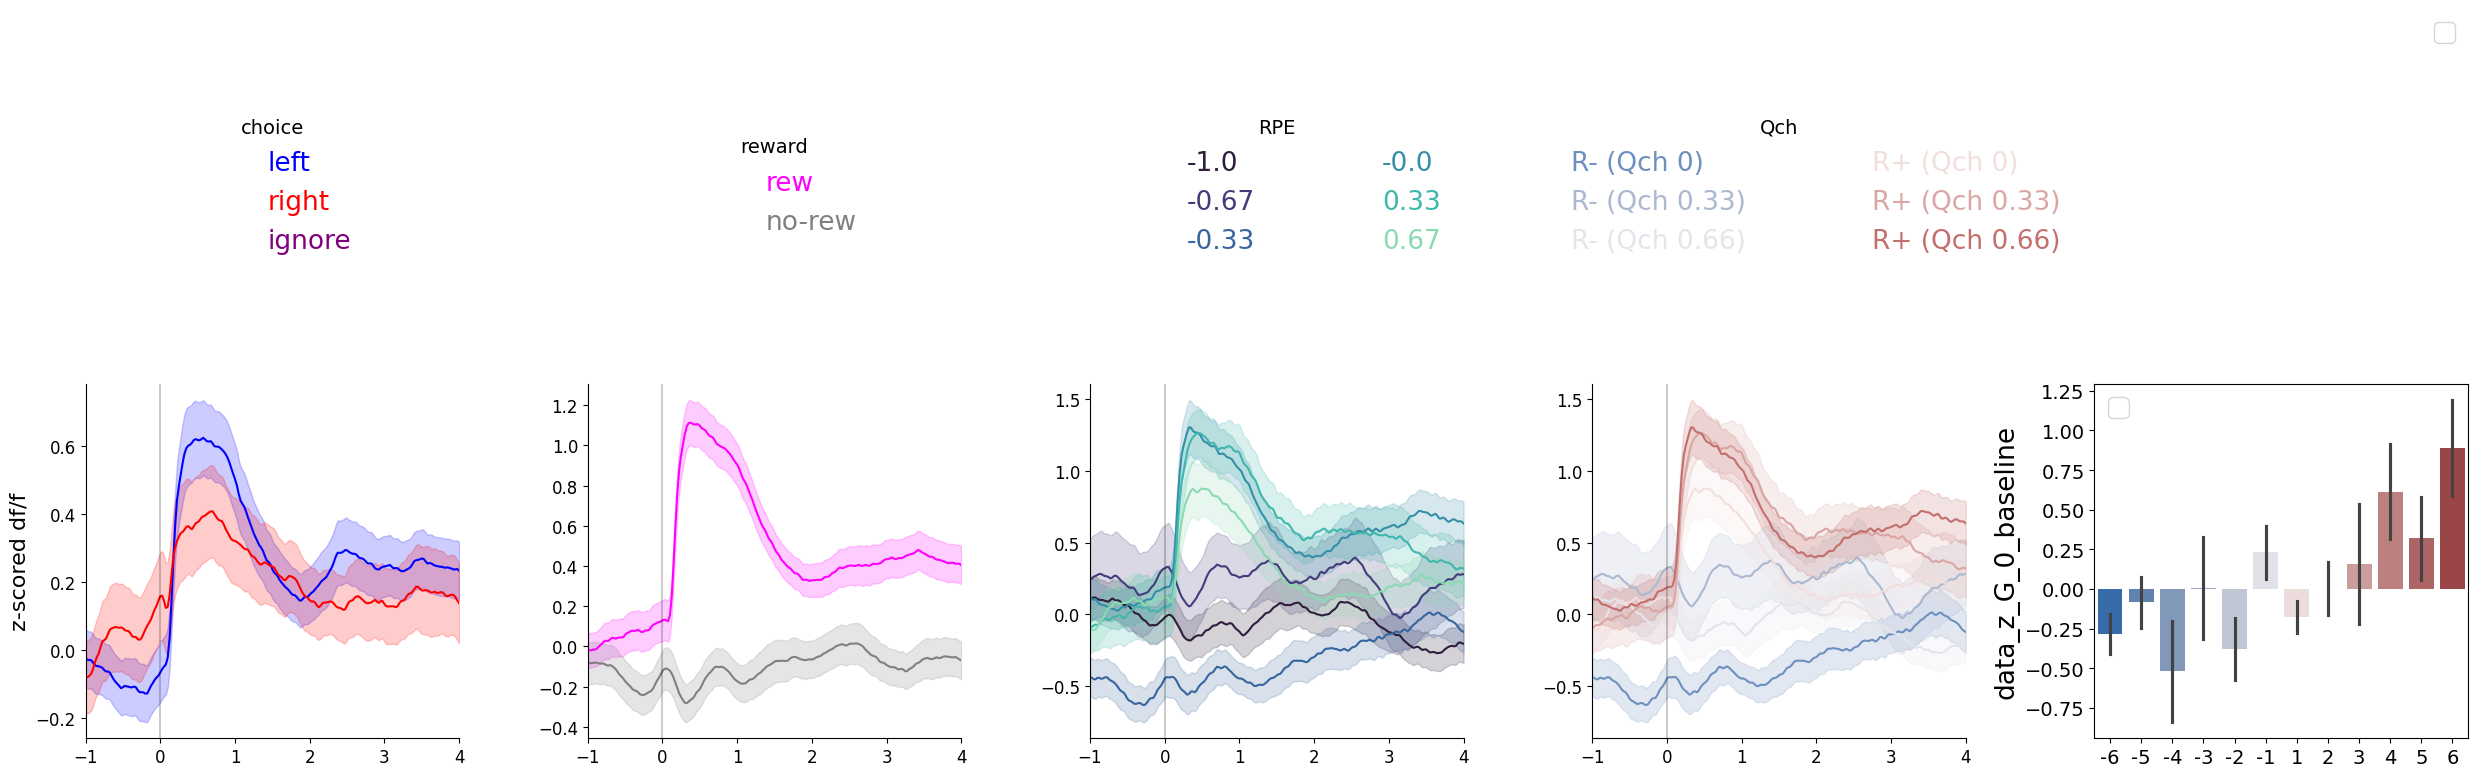

In [40]:
# make figure with 1 row and 5 columns and call the plotting helper
nwb = nwbs_by_week[0][0]
fig = plt.figure(figsize=(5 * 5, 8))

# top row: legend panels (1 x 5)
legend_axes = [fig.add_subplot(2, 5, i + 1) for i in range(5)]
plot_row_panels_PSTH([nwb], "", legend_axes, legend_panel=True)

# bottom row: actual PSTH panels (1 x 5)
psth_axes = [fig.add_subplot(2, 5, 5 + i + 1) for i in range(5)]
plot_row_panels_PSTH([nwb], "G_0", psth_axes, legend_panel=False)

plt.tight_layout()


In [72]:
Qch_binned3_label_names

['R- (Qch 0)',
 'R- (Qch 0.33)',
 'R- (Qch 0.66)',
 'R+ (Qch 0)',
 'R+ (Qch 0.33)',
 'R+ (Qch 0.66)']

In [73]:
nwb.df_trials["Qch-binned3"]

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
192    NaN
193    NaN
194    NaN
195    NaN
196    NaN
Name: Qch-binned3, Length: 197, dtype: category
Categories (6, object): ['R- (Qch 0)' < 'R- (Qch 0.33)' < 'R- (Qch 0.66)' < 'R+ (Qch 0)' < 'R+ (Qch 0.33)' < 'R+ (Qch 0.66)']

In [ ]:
def plot_all_sess(df_sess, nwbs_all, channel, channel_loc, loc=None):
    """
    plot_all_sess the DA version-- 
    plots L/R, split by RPE, baseline, split by RPE after baseline removal, slope for average response. 
    """
    # set pdf plot requirements
    mpl.rcParams['pdf.fonttype'] = 42 # allow text of pdf to be edited in illustrator
    mpl.rcParams["axes.spines.right"] = False
    mpl.rcParams["axes.spines.top"] = False


    nrows = len(nwbs_all)
    ncols = N_COLS_PER_ROW
    subject_id = df_sess['subject_id'].unique()[0]



    fig = plt.figure(figsize=(ncols*5, nrows*4))
    plt.suptitle(f"{subject_id} {channel_loc} ({channel})", fontsize = 16)

    outer = GridSpec(nrows, 1, figure=fig)

    # axes_rows will hold lists of 4 axes for each row; index 0 reserved for the top summary row (unused)
    axes_rows = [None] * nrows

    # -- Plot one row per session --- 
    for row, nwb in enumerate(nwbs_all):

        # create a small title row above the 4 panels using a nested GridSpec
        inner = GridSpecFromSubplotSpec(2, ncols, subplot_spec=outer[row], height_ratios=[0.12, 0.88], hspace=0.0, wspace=0.3)
        title_ax = fig.add_subplot(inner[0, :])
        title_ax.axis('off')
        title_ax.set_title(f"{nwb}", fontsize=16, fontweight='bold')

        # create the n_cols panel axes for this row
        panels = [fig.add_subplot(inner[1, col]) for col in range(ncols)]

        panels = plot_row_panels([nwb], channel, panels)
        axes_rows[row] = panels


    # set bottom row xlabels using the last row panels
    last_panels = axes_rows[-1]
    if last_panels is not None:
        last_panels[2].set_xlabel('num_reward_past')
        last_panels[0].set_xlabel('Time (s) from choice')
        last_panels[1].set_xlabel('Time (s) from choice')
        last_panels[-1].set_xlabel('Time (s) from choice')

    # show legends on the first data row (row index 1) if it exists
    if nrows > 1 and axes_rows[1] is not None:
        for (col, legend_title) in zip([0, 1, 3], ['choice', 'RPE', 'RPE']):
            axes_rows[1][col].legend(framealpha=0.5, title = legend_title, fontsize='small')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    if loc is not None:
        plt.savefig(f"{loc}all_sess_{subject_id}_{channel}.png",bbox_inches='tight',transparent = False, dpi = 1000)
        plt.close()

,trial,choice,rewarded_historyL,rewarded_historyR,side_bias,side_bias_confidence_interval,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,...,data_z_G_1_baseline,data_R_0_baseline,data_z_R_0_baseline,reward_all,num_reward_past,RPE-binned3,week_interval,avg_data_z_norm_R_0_choice_time,avg_data_z_norm_G_0_choice_time,avg_data_z_norm_G_1_choice_time
0,0,0.0,True,False,NaN,"[nan, nan]",True,True,0.8,0.7,...,-0.253120,2485.121382,0.714040,True,1,0.67,1,0.078969,1.050893,1.122472
1,1,0.0,True,False,NaN,"[nan, nan]",True,True,0.8,0.7,...,-0.834826,2428.392225,0.596711,True,2,0.33,1,1.150323,3.940241,4.558299
2,2,0.0,True,False,NaN,"[nan, nan]",True,True,0.8,0.7,...,1.712887,3389.024622,2.583516,True,3,-0.0,1,0.350892,1.052745,1.570548
3,3,0.0,True,False,NaN,"[nan, nan]",True,True,0.8,0.7,...,1.205047,3328.141685,2.457596,True,4,-0.0,1,0.756732,2.356876,1.727903
4,4,0.0,True,False,NaN,"[nan, nan]",True,True,0.8,0.7,...,0.635668,3169.831533,2.130175,True,5,-0.0,1,0.570183,2.047199,2.226870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,276,1.0,False,True,NaN,"[nan, nan]",False,True,0.8,0.1,...,-1.325052,1585.814255,-1.145931,True,1,0.67,1,0.014622,0.155704,0.609415
193,285,1.0,False,True,NaN,"[nan, nan]",False,True,0.8,0.1,...,-1.360709,1543.471274,-1.233506,True,1,0.33,1,0.053791,0.063956,0.284147
194,287,1.0,False,False,NaN,"[nan, nan]",True,False,0.8,0.7,...,-1.879338,1636.039741,-1.042053,False,-2,-1.0,1,-0.077024,-0.618143,0.101645
195,296,1.0,False,False,NaN,"[nan, nan]",True,False,0.8,0.7,...,-1.634625,1652.575378,-1.007854,False,-11,-0.67,1,-0.056925,-0.727662,0.025982
